In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
import optuna


# Импорт библиотек

In [19]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
479,480,1,3,"Hirvonen, Miss. Hildur E",female,2.0,0,1,3101298,12.2875,NaN,S
773,774,0,3,"Elias, Mr. Dibo",male,NaN,0,0,2674,7.2250,NaN,C
738,739,0,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S


## Выставление настроек

In [20]:
2+2

4

# Обработка данных

Начнем с того, что приведем все названия колонок к "змеиной нотации"

In [21]:
df.columns = df.columns.str.lower()
test.columns = test.columns.str.lower()

Переведем колонку с индексом в индекс датафрейма

In [22]:
df = df.set_index('passengerid')
test = test.set_index('passengerid')

Выведем общую информацию об обучающем и тестовом датасетах

In [23]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [24]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
survived,891,0,int64,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891,0,int64,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
name,891,0,object,,,,,,,,
sex,891,0,object,,,,,,,,
age,714,177,float64,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891,0,int64,891.0,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891,0,int64,891.0,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
ticket,891,0,object,,,,,,,,
fare,891,0,float64,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
cabin,204,687,object,,,,,,,,


In [25]:
full_info(test)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
pclass,418,0,int64,418.0,2.26555,0.841838,1.0,1.0,3.0,3.0,3.0
name,418,0,object,,,,,,,,
sex,418,0,object,,,,,,,,
age,332,86,float64,332.0,30.27259,14.181209,0.17,21.0,27.0,39.0,76.0
sibsp,418,0,int64,418.0,0.447368,0.89676,0.0,0.0,0.0,1.0,8.0
parch,418,0,int64,418.0,0.392344,0.981429,0.0,0.0,0.0,0.0,9.0
ticket,418,0,object,,,,,,,,
fare,417,1,float64,417.0,35.627188,55.907576,0.0,7.8958,14.4542,31.5,512.3292
cabin,91,327,object,,,,,,,,
embarked,418,0,object,,,,,,,,


Выводы следующие:
* В обучающем датасете 891 наблюдение
* Пропуски есть в колонках с возрастом и номером кабины(?). Пропуски есть также и в тестовом датасете, поэтому модель должна уметь работать с ними
* Не все типы данных оптимальны
* есть небольшой дисбаланс в пользу погибших

Удалим признак с номером кабины, так как восстановить эту информацию и использовать далее не удастся

In [26]:
try:
    df = df.drop('cabin', axis=1)
    test = test.drop('cabin', axis=1)
except:
    print('Признака уже нет')

Поменяем типы данных

In [27]:
df['pclass'] = df['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})
test['pclass'] = test['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})

In [28]:
df['sex'] = df['sex'].replace({'male': 0, 'female': 1}).astype('bool')
test['sex'] = test['sex'].replace({'male': 0, 'female': 1}).astype('bool')

Добавим новый признак, равный длине имени. Позже проверим, как это влияет на шансы выжить

In [29]:
df['name_length'] = df['name'].apply(len)
test['name_length'] = test['name'].apply(len)

Посмотрим на признак "номер билета"

In [30]:
df['ticket'].value_counts()

ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Совпадающих значений мало, удалим признак

In [31]:
df = df.drop('ticket', axis=1)
test = test.drop('ticket', axis=1)

# Исследование данных

Построим по порядку для всех признаков графики, позволяющие пока визуально оценить влияние признака на целевую переменную

## Номер класса

In [32]:
df.groupby('pclass')['survived'].value_counts(normalize=True).round(2)

pclass  survived
first   1           0.63
        0           0.37
second  0           0.53
        1           0.47
third   0           0.76
        1           0.24
Name: proportion, dtype: float64

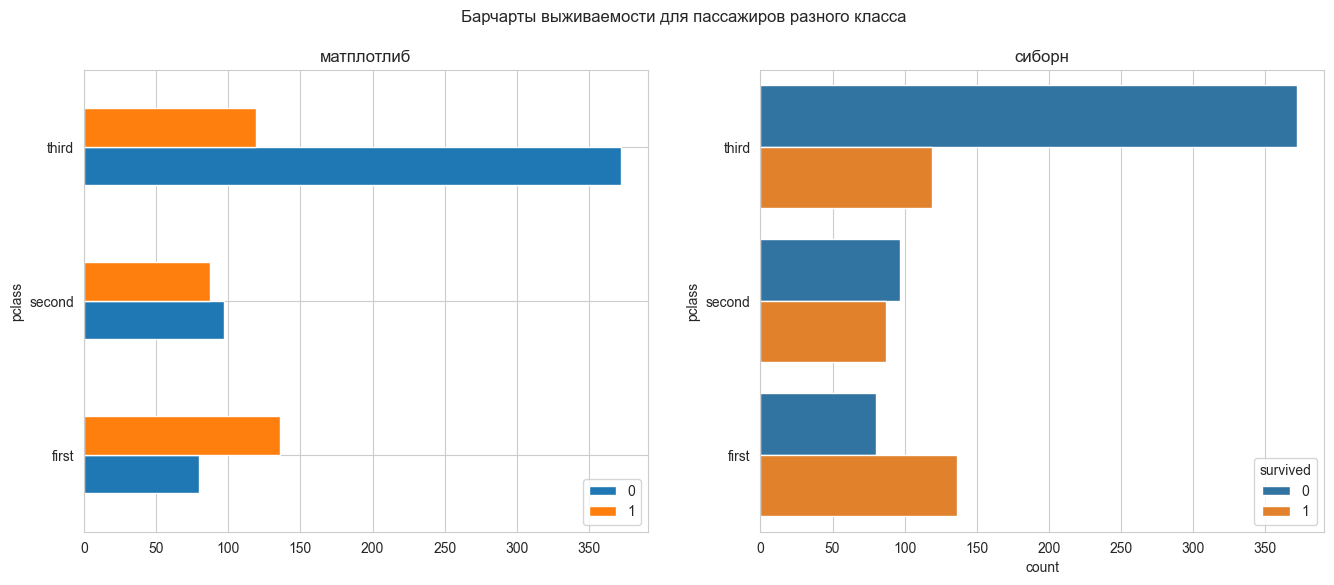

In [33]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle('Барчарты выживаемости для пассажиров разного класса')
df.groupby(['pclass', 'survived'])['survived'].value_counts().unstack().plot.barh(ax=ax1);
ax1.legend(loc='lower right');
ax1.set_title('матплотлиб')

sns.barplot(data=df.groupby(['pclass', 'survived'])['survived'].value_counts().reset_index(),
            y='pclass',
            order=['third', 'second', 'first'],
            x='count',
            hue='survived',
            # hue_order=[0, 1],
            orient='h',
            ax=ax2);
ax2.set_title('сиборн');

Предсказуемо, шансы выжить у пассажиров первого класса были выше

## Имя

Проверим, существует ли связь между длиной имени и вероятностью выжить.

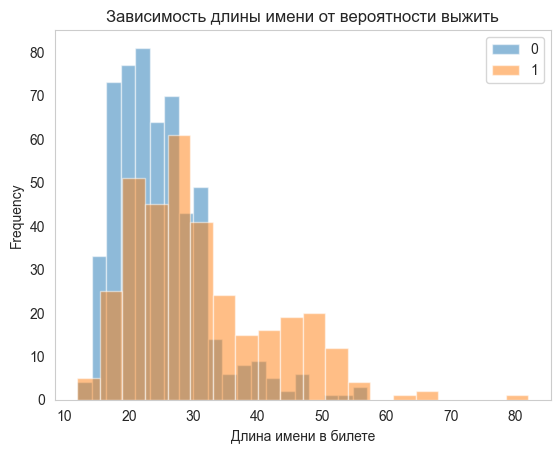

In [34]:
df.groupby('survived')['name_length'].plot(bins=20, alpha=0.5, kind='hist', grid=False);
plt.legend();
plt.title('Зависимость длины имени от вероятности выжить')
plt.xlabel('Длина имени в билете');

Удалим признак с именем

In [35]:
df = df.drop('name', axis=1)

## Пол

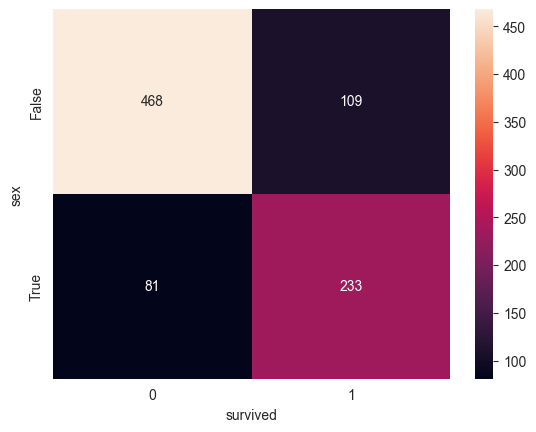

In [36]:
sns.heatmap(df.groupby(['sex', 'survived'])['survived'].count().unstack(), annot=True, fmt='.3g');

Среди женщин выжило примерно 75%, среди мужчин - 20%

## Возраст

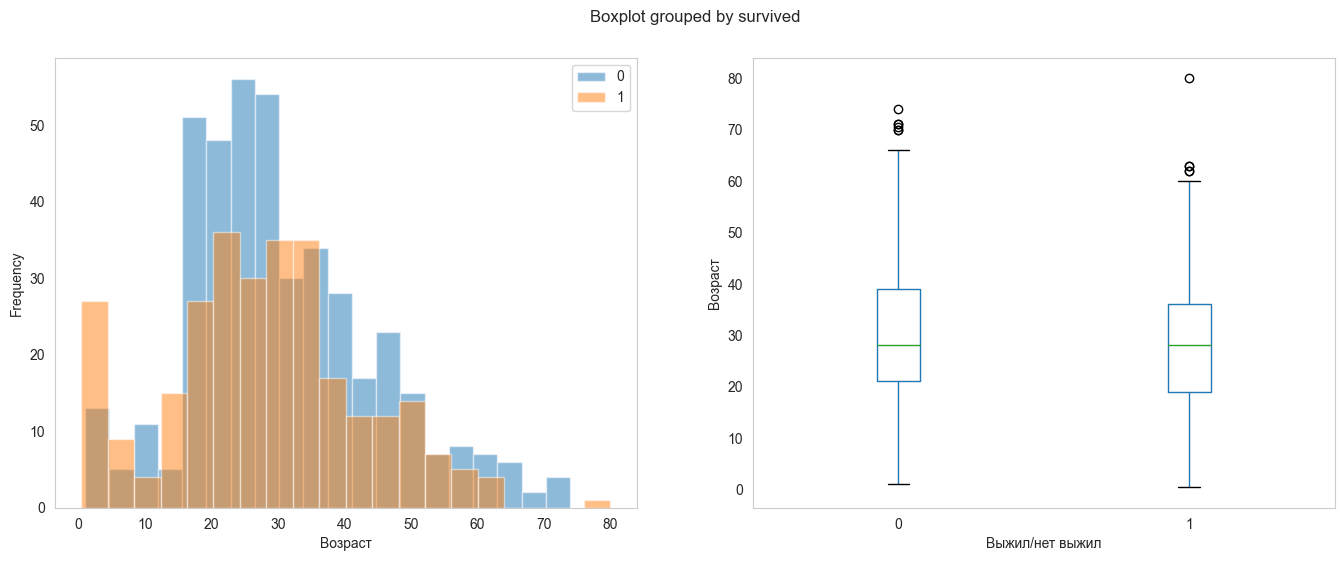

In [37]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

# fig.title('a')
fig.suptitle('b')
plt.title('c')
plt.suptitle('d')

df.groupby('survived')['age'].plot(bins=20, alpha=0.5, kind='hist', grid=False, ax=ax1);
ax1.legend();
ax1.set_xlabel('Возраст');

df.boxplot(column='age', by='survived', grid=False, ax=ax2);
ax2.set_xlabel('');
ax2.set_title('')
ax2.set_xlabel('Выжил/нет выжил')
ax2.set_ylabel('Возраст');

# Обучение моделей

## Разделение датасета на признаки и таргет, на обучающую и тестовую выборки

In [38]:
x = df.drop('survived', axis=1)
y = df['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

## Создание таблицы с результатами

In [138]:
final_score = pd.DataFrame(columns=('model', 'searcher', 'params', 'cv_roc_auc', 'train_roc_auc', 'test_roc_auc'))

Напишем функцию, заполняющую таблицу с результатами

In [139]:
def final_scorer(model_name='unknown',
                 searcher='unknown',
                 best_params={},
                 cv_best_score=np.nan,
                 train_roc_auc=np.nan,
                 test_roc_auc=np.nan):
    index = final_score.shape[0] + 1

    final_score.loc[index, 'model'] = model_name
    final_score.loc[index, 'searcher'] = searcher
    final_score.loc[index, 'params'] = list(best_params.items())
    final_score.loc[index, 'cv_roc_auc'] = round(cv_best_score, 4)
    final_score.loc[index, 'train_roc_auc'] = round(train_roc_auc, 4)
    final_score.loc[index, 'test_roc_auc'] = round(test_roc_auc, 4)

    return final_score


In [140]:
final_scorer('lr', 'some', {'d': 3}, 5.6, 6.24543535)

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN


## Линейные модели

Построим пайплайн преобразования признаков для линейной модели

In [141]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                remainder='passthrough')
Pipeline(steps=[('', transformer)])

Pipeline(steps=[('',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026DA1804670>),
                                                 ('cats',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026DA1804A90>)]))])

Посмотрим на получившиеся признаки. У них теперь нет имен, но по порядку преобразвоаний можно увидеть, что последние 4 признака - это категориальные признаки, подвергнутые OHE.

In [142]:
full_info(pd.DataFrame(transformer.fit_transform(x_train)).astype('float'))

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
0,712,0,float64,712.0,2.993860e-17,1.000703,-0.737881,-0.737881,-0.737881,1.355232,1.355232
1,712,0,float64,712.0,-2.183023e-16,1.000703,-2.310194,-0.615224,0.000000,0.405842,3.940300
2,712,0,float64,712.0,5.738231e-17,1.000703,-0.460103,-0.460103,-0.460103,0.437413,6.720019
3,712,0,float64,712.0,-1.247442e-17,1.000703,-0.474312,-0.474312,-0.474312,-0.474312,6.045189
4,712,0,float64,712.0,-7.235161e-17,1.000703,-0.620689,-0.469374,-0.361976,-0.044414,9.197546
5,712,0,float64,712.0,-1.459507e-16,1.000703,-1.640237,-0.749089,-0.192122,0.364845,4.486401
6,712,0,float64,712.0,2.092697e-01,0.407073,0.000000,0.000000,0.000000,0.000000,1.000000
7,712,0,float64,712.0,5.575843e-01,0.497022,0.000000,0.000000,1.000000,1.000000,1.000000
8,712,0,float64,712.0,9.410112e-02,0.292175,0.000000,0.000000,0.000000,0.000000,1.000000
9,712,0,float64,712.0,7.261236e-01,0.446260,0.000000,0.000000,1.000000,1.000000,1.000000


Добавим в пайплайн классификатор

In [143]:
lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression(random_state=123))])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          },
          { 'transformer__nums__imputer': [IterativeImputer(random_state=123)],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_;

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [144]:
display(pd.DataFrame(lr_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {lr_gs.best_params_}',
      f'\nroc-auc: {lr_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__nums__imputer__strategy,param_transformer__nums__imputer,param_clf__penalty,param_clf__C,std_score_time,mean_score_time,std_fit_time,mean_fit_time
23,1,0.032609,0.855235,0.886582,0.810270,0.868854,"{'clf__C': 100, 'clf__penalty': 'l2', 'transfo...",NaN,IterativeImputer(random_state=123),l2,100,0.000943,0.010665,0.002624,0.061526
20,2,0.032643,0.855210,0.886582,0.810195,0.868854,"{'clf__C': 10, 'clf__penalty': 'none', 'transf...",NaN,IterativeImputer(random_state=123),none,10,0.000525,0.013732,0.001714,0.064064
18,2,0.032643,0.855210,0.886582,0.810195,0.868854,"{'clf__C': 1, 'clf__penalty': 'none', 'transfo...",NaN,IterativeImputer(random_state=123),none,1,0.001247,0.018334,0.004898,0.072999
16,2,0.032643,0.855210,0.886582,0.810195,0.868854,"{'clf__C': 0.1, 'clf__penalty': 'none', 'trans...",NaN,IterativeImputer(random_state=123),none,0.1,0.000942,0.014669,0.005249,0.069609
22,2,0.032643,0.855210,0.886582,0.810195,0.868854,"{'clf__C': 100, 'clf__penalty': 'none', 'trans...",NaN,IterativeImputer(random_state=123),none,100,0.000818,0.012999,0.002356,0.061860
21,6,0.032868,0.854835,0.886207,0.809445,0.868854,"{'clf__C': 10, 'clf__penalty': 'l2', 'transfor...",NaN,IterativeImputer(random_state=123),l2,10,0.000815,0.012999,0.002159,0.065194
12,7,0.033457,0.854610,0.886507,0.808396,0.868928,"{'clf__C': 100, 'clf__penalty': 'none', 'trans...",mean,SimpleImputer(),none,100,0.000472,0.012516,0.000819,0.031049
8,7,0.033457,0.854610,0.886507,0.808396,0.868928,"{'clf__C': 10, 'clf__penalty': 'none', 'transf...",mean,SimpleImputer(),none,10,0.000458,0.013336,0.000816,0.032482
0,7,0.033457,0.854610,0.886507,0.808396,0.868928,"{'clf__C': 0.1, 'clf__penalty': 'none', 'trans...",mean,SimpleImputer(),none,0.1,0.000487,0.013447,0.000639,0.044206
4,7,0.033457,0.854610,0.886507,0.808396,0.868928,"{'clf__C': 1, 'clf__penalty': 'none', 'transfo...",mean,SimpleImputer(),none,1,0.001415,0.012998,0.004988,0.037073


параметры: {'clf__C': 100, 'clf__penalty': 'l2', 'transformer__nums__imputer': IterativeImputer(random_state=123)} 
roc-auc: 0.8552


In [157]:
final_scorer(model_name='Logistic Regression',
             searcher='GridSearchCV',
             best_params=lr_gs.best_params_,
             cv_best_score=lr_gs.best_score_,
             train_roc_auc=roc_auc_score(y_train, lr_gs.best_estimator_.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, lr_gs.best_estimator_.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648


In [26]:
lr = lr_gs.best_estimator_

Классификатор обучен и может уже что-то предсказывать. Посмотрим на важность признаков с точки зрения коэффициентов логистической регрессии и permutation_importance

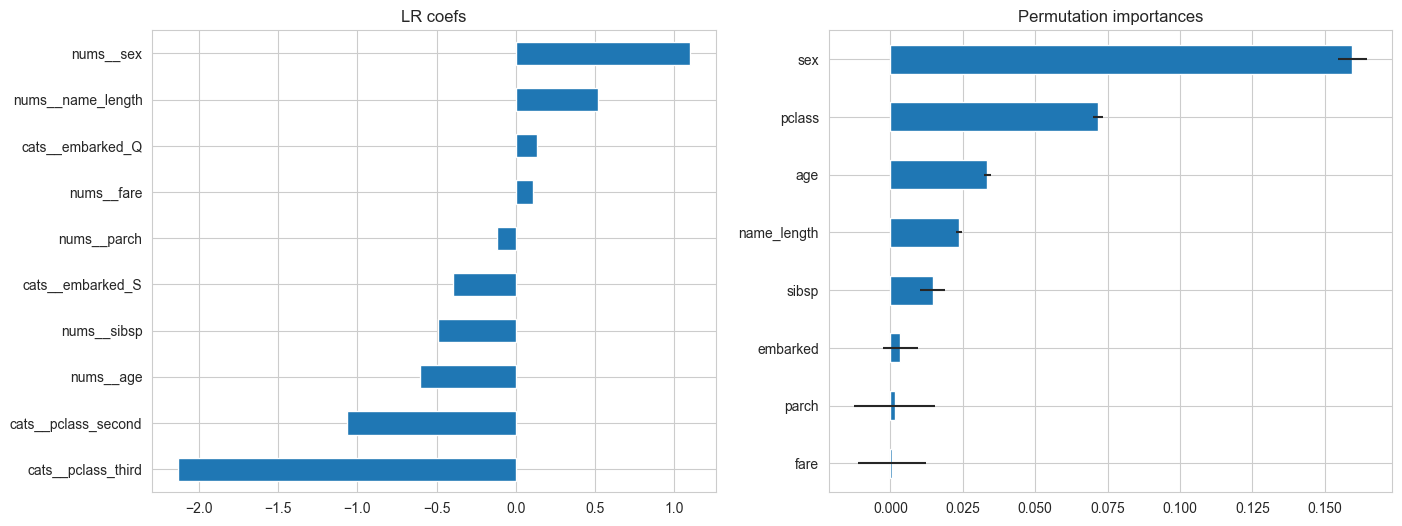

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

pd.Series(lr.named_steps['clf'].coef_.reshape(-1), index=lr.named_steps['transformer'].get_feature_names_out()).sort_values().plot.barh(ax=ax1);
ax1.set_title('LR coefs');

r = permutation_importance(lr, x_train, y_train, scoring='roc_auc', n_repeats=30, random_state=123)
pd.Series(r.importances_mean, index=x_train.columns).sort_values().plot.barh(xerr=r.importances_std, ax=ax2);
ax2.set_title('Permutation importances');

### Добавление полиномиальных признаков

In [28]:
num_ct_poly = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                              ('scaler', StandardScaler()),
                              ('poly', PolynomialFeatures())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer_poly = ColumnTransformer(transformers=[('nums', num_ct_poly, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

clf_lr = LogisticRegression()
# lr_pipe = Pipeline(steps=[('transformer', transformer_poly), ('clf', clf_lr)])
#
# lr_pipe.fit(x, y)

In [29]:
rfe = RFE(clf_lr)

In [30]:
# создание словаря с признаками после всех преобразований можно было использовать rfe.support_
poly_features = pd.DataFrame({f'x{i}': transformer_poly.fit_transform(x_train)[: , i] for i in range(1, transformer_poly.fit_transform(x_train).shape[1])})
poly_features.sample()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31
632,1.355232,0.633343,-0.460103,-0.474312,-0.371558,-0.192122,1.836653,0.858326,-0.623546,-0.642803,...,0.224972,0.176234,0.091126,0.138055,0.071385,0.036911,1.0,0.0,0.0,1.0


In [31]:
rfe.fit(poly_features, y_train)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFE(estimator=LogisticRegression())

In [32]:
rfe.ranking_

array([ 1,  1, 14, 11,  1,  1,  1,  1, 10,  2,  1,  1,  7,  1,  1,  1,  9,
        1, 15, 17,  8,  5, 12,  3, 13, 16,  6,  1,  1,  4,  1])

In [33]:
rfe.estimator_.coef_

array([[ 0.91629682, -0.35695898,  0.21786848,  0.52987345,  0.56544174,
         0.37042107,  0.47137532, -0.27034299,  0.18905224, -0.49893444,
         0.58547265, -0.27852124, -0.82206213, -1.63396132, -0.49676722]])

In [34]:
rfe_imp_features = rfe.get_feature_names_out()
rfe_imp_features.shape

(15,)

In [35]:
cross_val_score(clf_lr, poly_features[rfe_imp_features], y_train, cv=3, scoring='roc_auc').mean()

0.868694147549881

### Встраивание RFE в Gridsearch

In [36]:
# класс, который возвращает коэффициенты логистической регрессии
# https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns

class MyPipe(Pipeline):

    def fit(self, X, y=None, **fit_params):
        """Calls last elements .coef_ method.
        Based on the sourcecode for decision_function(X).
        Link: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py
        ----------
        """
        super(MyPipe, self).fit(X, y, **fit_params)
        self.coef_ = self.steps[-1][-1].coef_
        return self

In [37]:
num_ct_poly = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                              ('scaler', StandardScaler()),
                              ('poly', PolynomialFeatures())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer_poly = ColumnTransformer(transformers=[('nums', num_ct_poly, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

x_poly = transformer_poly.fit_transform(x_train)

params = [{'rfe__estimator__penalty': [None, 'l2'],
           'rfe__estimator__C': [0.1, 1, 10, 100],
           'rfe__n_features_to_select': range(5, 20)
          }]

clf_lr = LogisticRegression()
rfe = RFE(estimator=clf_lr, verbose=99)

lr_pipe_poly = Pipeline(steps=[('transformer', transformer_poly), ('rfe', rfe)])

lr_gs_poly=GridSearchCV(estimator=lr_pipe_poly,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)

lr_gs_poly.fit(x_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('nums',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(random_state=123)),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000022EB007ECA0>),
                                                                        ('cats',
                                                                         Pipeline(s...
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000022EB007EC70>)])),
                                       ('rfe',
                                        RFE(estimator=LogisticRegression(),
                                            verbose=99))]),
             n_jobs=-1,
             param_grid=[{'rfe__estimator__C': [0.1, 1, 10, 100],
                          'rfe__estimator__penalty': [None, 'l2'],
                          'rfe__n_features_to_select': range(5, 20)}],
             scoring='roc_auc', verbose=10)

In [38]:
pd.DataFrame(lr_gs_poly.cv_results_).sort_values('rank_test_score').head(33)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__estimator__C,param_rfe__estimator__penalty,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,0.273665,0.013425,0.014002,9.199649e-07,0.1,l2,14,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.876863,0.811019,0.890555,0.859479,0.034719,1
85,0.456002,0.027314,0.014666,9.429095e-04,10,l2,15,"{'rfe__estimator__C': 10, 'rfe__estimator__pen...",0.875454,0.821664,0.880960,0.859359,0.026749,2
115,0.427668,0.110551,0.013333,2.493960e-03,100,l2,15,"{'rfe__estimator__C': 100, 'rfe__estimator__pe...",0.875232,0.821064,0.881409,0.859235,0.027108,3
11,0.344000,0.021275,0.013666,4.715406e-04,0.1,None,16,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.875158,0.821139,0.881334,0.859210,0.027038,4
41,0.327333,0.017517,0.013000,1.173403e-06,1,None,16,"{'rfe__estimator__C': 1, 'rfe__estimator__pena...",0.875158,0.821139,0.881334,0.859210,0.027038,4
101,0.363332,0.042501,0.015334,2.624600e-03,100,None,16,"{'rfe__estimator__C': 100, 'rfe__estimator__pe...",0.875158,0.821139,0.881334,0.859210,0.027038,4
71,0.384000,0.029676,0.014333,4.712026e-04,10,None,16,"{'rfe__estimator__C': 10, 'rfe__estimator__pen...",0.875158,0.821139,0.881334,0.859210,0.027038,4
26,0.250666,0.013426,0.014335,4.718762e-04,0.1,l2,16,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.875380,0.816567,0.883208,0.858385,0.029742,8
25,0.269000,0.014990,0.014666,1.248063e-03,0.1,l2,15,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.874713,0.814543,0.885307,0.858188,0.031163,9
28,0.263332,0.013572,0.018334,4.190346e-03,0.1,l2,18,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.877308,0.812369,0.884858,0.858178,0.032538,10


НИЧЕГО НЕ ПОЛУЧИЛОСЬ

### Метод опорных векторов

#### SVC

In [159]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

# Параметр probability нужен, чтобы вернулись predict_proba. Это нужно для построения roc-auc и soft-voting
svm_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', SVC(random_state=123, probability=True))])

params = {'transformer__nums__scaler': [StandardScaler(), MinMaxScaler()],
          'estimator__C': range(1, 20),
          'estimator__gamma': [i/10000 for i in range(10)]}

gs_svc = GridSearchCV(svm_pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True)

gs_svc.fit(x_train, y_train)
# {'estimator__C': 9, 'estimator__gamma': 0.009
svm_best = gs_svc.best_estimator_


CPU times: total: 5.55 s
Wall time: 23.6 s


In [160]:
display(pd.DataFrame(gs_svc.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {gs_svc.best_params_}',
      f'\nroc-auc: {gs_svc.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__nums__scaler,param_estimator__gamma,param_estimator__C,std_score_time,mean_score_time,std_fit_time,mean_fit_time
319,1,0.035841,0.848618,0.885157,0.799925,0.860771,"{'estimator__C': 16, 'estimator__gamma': 0.000...",MinMaxScaler(),0.0009,16,0.001247,0.029667,0.006129,0.160669
379,2,0.037244,0.848593,0.886882,0.798126,0.860771,"{'estimator__C': 19, 'estimator__gamma': 0.000...",MinMaxScaler(),0.0009,19,0.000471,0.015334,0.003560,0.100000
299,3,0.035381,0.848572,0.885232,0.800750,0.859733,"{'estimator__C': 15, 'estimator__gamma': 0.000...",MinMaxScaler(),0.0009,15,0.001246,0.032332,0.018857,0.159332
357,4,0.035893,0.848518,0.885157,0.799775,0.860623,"{'estimator__C': 18, 'estimator__gamma': 0.000...",MinMaxScaler(),0.0008,18,0.001247,0.030331,0.007762,0.141668
375,5,0.035358,0.848498,0.885232,0.800750,0.859511,"{'estimator__C': 19, 'estimator__gamma': 0.000...",MinMaxScaler(),0.0007,19,0.000816,0.031998,0.005097,0.139001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,343,0.000000,0.500000,0.500000,0.500000,0.500000,"{'estimator__C': 14, 'estimator__gamma': 0.0, ...",MinMaxScaler(),0.0,14,0.000471,0.031334,0.003740,0.125001
260,343,0.000000,0.500000,0.500000,0.500000,0.500000,"{'estimator__C': 14, 'estimator__gamma': 0.0, ...",StandardScaler(),0.0,14,0.001413,0.034000,0.003860,0.131332
80,343,0.000000,0.500000,0.500000,0.500000,0.500000,"{'estimator__C': 5, 'estimator__gamma': 0.0, '...",StandardScaler(),0.0,5,0.016048,0.053666,0.004921,0.125754
300,343,0.000000,0.500000,0.500000,0.500000,0.500000,"{'estimator__C': 16, 'estimator__gamma': 0.0, ...",StandardScaler(),0.0,16,0.004321,0.037002,0.009179,0.135330


параметры: {'estimator__C': 16, 'estimator__gamma': 0.0009, 'transformer__nums__scaler': MinMaxScaler()} 
roc-auc: 0.8486


In [161]:
final_scorer(model_name='SVC',
             searcher='GridSearchCV',
             best_params=gs_svc.best_params_,
             cv_best_score=gs_svc.best_score_,
             train_roc_auc=roc_auc_score(y_train, gs_svc.best_estimator_.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, gs_svc.best_estimator_.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505


#### LinearSVC

In [163]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

svm_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', LinearSVC(max_iter=100000, random_state=123))])

params = {'transformer__nums__scaler': [StandardScaler(), MinMaxScaler()],
          'estimator__C': [2*i/100 for i in range(1, 100)]}

gs_lsvm = GridSearchCV(svm_pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True, error_score='raise')
gs_lsvm.fit(x_train, y_train);
lsvm_best = gs_lsvm.best_estimator_

CPU times: total: 2.03 s
Wall time: 6.89 s


In [164]:
display(pd.DataFrame(gs_lsvm.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {gs_lsvm.best_params_}',
      f'\nroc-auc: {gs_lsvm.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__nums__scaler,param_estimator__C,std_score_time,mean_score_time,std_fit_time,mean_fit_time
189,1,0.032169,0.855376,0.884258,0.810495,0.871376,"{'estimator__C': 1.9, 'transformer__nums__scal...",MinMaxScaler(),1.9,8.159508e-04,0.012000,0.003400,0.058333
191,2,0.032156,0.855351,0.884258,0.810495,0.871301,"{'estimator__C': 1.92, 'transformer__nums__sca...",MinMaxScaler(),1.92,9.427408e-04,0.012667,0.002053,0.058666
187,2,0.032156,0.855351,0.884258,0.810495,0.871301,"{'estimator__C': 1.88, 'transformer__nums__sca...",MinMaxScaler(),1.88,1.413943e-03,0.013000,0.001632,0.058000
183,4,0.032191,0.855326,0.884258,0.810420,0.871301,"{'estimator__C': 1.84, 'transformer__nums__sca...",MinMaxScaler(),1.84,1.246045e-03,0.013334,0.001459,0.057502
185,4,0.032191,0.855326,0.884258,0.810420,0.871301,"{'estimator__C': 1.86, 'transformer__nums__sca...",MinMaxScaler(),1.86,4.717077e-04,0.012334,0.000942,0.057333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,194,0.032961,0.851240,0.880435,0.805172,0.868113,"{'estimator__C': 0.1, 'transformer__nums__scal...",MinMaxScaler(),0.1,8.172161e-04,0.014000,0.028523,0.115333
7,195,0.033166,0.850720,0.880735,0.804498,0.866926,"{'estimator__C': 0.08, 'transformer__nums__sca...",MinMaxScaler(),0.08,1.885931e-03,0.014333,0.007587,0.061333
5,196,0.032862,0.850200,0.880660,0.804573,0.865369,"{'estimator__C': 0.06, 'transformer__nums__sca...",MinMaxScaler(),0.06,1.700299e-03,0.015333,0.011557,0.065667
3,197,0.032499,0.849183,0.879835,0.804198,0.863515,"{'estimator__C': 0.04, 'transformer__nums__sca...",MinMaxScaler(),0.04,1.246577e-03,0.013666,0.004027,0.053667


параметры: {'estimator__C': 1.9, 'transformer__nums__scaler': MinMaxScaler()} 
roc-auc: 0.8554


In [169]:
final_scorer(model_name='LinearSVC',
             searcher='GridSearchCV',
             best_params=gs_lsvm.best_params_,
             cv_best_score=gs_lsvm.best_score_,
             train_roc_auc=roc_auc_score(y_train, gs_lsvm.best_estimator_.decision_function(x_train)),
             test_roc_auc=roc_auc_score(y_test, gs_lsvm.best_estimator_.decision_function(x_test)))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505
4,LinearSVC,GridSearchCV,"[(estimator__C, 1.9), (transformer__nums__scal...",0.8554,0.8616,0.8625


## Наивный Байес

In [170]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', MinMaxScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer_poly = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

bayes_pipe = Pipeline(steps=[('transformer', transformer_poly), ('estimator', BernoulliNB())])

params = [{'estimator': [BernoulliNB(), CategoricalNB(), ComplementNB()],
           'estimator__alpha': [0.1, 1, 10]},

          {'estimator': [GaussianNB()]}
         ]

gs_bayes = GridSearchCV(bayes_pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1)

gs_bayes.fit(x_train, y_train);

CPU times: total: 172 ms
Wall time: 5.78 s


In [171]:
display(pd.DataFrame(gs_bayes.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {gs_bayes.best_params_}',
      f'\nroc-auc: {gs_bayes.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_estimator__alpha,param_estimator,std_score_time,mean_score_time,std_fit_time,mean_fit_time
7,1,0.033375,0.832073,0.867766,0.787481,0.840971,"{'estimator': ComplementNB(alpha=1), 'estimato...",1,ComplementNB(alpha=1),0.001227,0.015351,0.003299,0.057724
6,2,0.032532,0.831672,0.865892,0.787931,0.841194,"{'estimator': ComplementNB(alpha=1), 'estimato...",0.1,ComplementNB(alpha=1),0.000447,0.013685,0.012484,0.070404
8,3,0.034526,0.830656,0.868216,0.784858,0.838895,"{'estimator': ComplementNB(alpha=1), 'estimato...",10,ComplementNB(alpha=1),0.008765,0.019689,0.002449,0.058058
9,4,0.026125,0.828027,0.860720,0.796777,0.826585,{'estimator': GaussianNB()},NaN,GaussianNB(),0.003304,0.015400,0.005443,0.059732
0,5,0.032430,0.819763,0.854648,0.776537,0.828105,"{'estimator': BernoulliNB(), 'estimator__alpha...",0.1,BernoulliNB(),0.004642,0.014332,0.011029,0.080728
1,6,0.034377,0.819366,0.856897,0.773838,0.827364,"{'estimator': BernoulliNB(), 'estimator__alpha...",1,BernoulliNB(),0.064283,0.096998,0.031480,0.110334
4,7,0.031300,0.819178,0.854835,0.778636,0.824064,"{'estimator': CategoricalNB(), 'estimator__alp...",1,CategoricalNB(),0.030473,0.037000,0.028295,0.113998
3,8,0.028991,0.818925,0.850937,0.780735,0.825102,"{'estimator': CategoricalNB(), 'estimator__alp...",0.1,CategoricalNB(),0.002490,0.014335,0.006147,0.053348
5,9,0.031876,0.818456,0.854835,0.777211,0.823322,"{'estimator': CategoricalNB(), 'estimator__alp...",10,CategoricalNB(),0.011121,0.038684,0.032714,0.205666
2,10,0.035050,0.817601,0.856447,0.771514,0.824842,"{'estimator': BernoulliNB(), 'estimator__alpha...",10,BernoulliNB(),0.001222,0.014684,0.005130,0.070102


параметры: {'estimator': ComplementNB(alpha=1), 'estimator__alpha': 1} 
roc-auc: 0.8321


In [172]:
final_scorer(model_name='Naive Bayes',
             searcher='GridSearchCV',
             best_params=gs_bayes.best_params_,
             cv_best_score=gs_bayes.best_score_,
             train_roc_auc=roc_auc_score(y_train, gs_bayes.best_estimator_.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, gs_bayes.best_estimator_.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505
4,LinearSVC,GridSearchCV,"[(estimator__C, 1.9), (transformer__nums__scal...",0.8554,0.8616,0.8625
5,Naive Bayes,GridSearchCV,"[(estimator, ComplementNB(alpha=1)), (estimato...",0.8321,0.8348,0.858


## Деревянные модели

### Дерево решений

In [173]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

tree_pipe = Pipeline(steps=[('transformer', transformer), ('clf', DecisionTreeClassifier(random_state=123))])

tree_params = {'transformer__cats__encoder': [OneHotEncoder(drop='first'), LabelEncoder()],
               'clf__max_depth': [2, 3, 4, 5, 7, 9],
               'clf__min_samples_split': [2, 3, 4, 5, 6, 8, 9, 10, 11],
               'clf__min_samples_leaf': [3, 5, 8, 9, 10, 11, 12, 14, 16]}

tree_gs = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='roc_auc', cv=3, n_jobs=-1)
tree_gs.fit(x_train, y_train);
tree_best = tree_gs.best_estimator_

CPU times: total: 9.81 s
Wall time: 24.7 s


C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1458 fits failed out of a total of 2916.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1458 fits failed with the following error:
Traceback (most recent call last):
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\pipeline.p

In [174]:
display(pd.DataFrame(tree_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {tree_gs.best_params_}',
      f'\nroc-auc: {tree_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__cats__encoder,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
494,1,0.033613,0.839459,0.837256,0.799438,0.881683,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),6,3,5,0.020510,0.028000,0.038193,0.082000
492,1,0.033613,0.839459,0.837256,0.799438,0.881683,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),5,3,5,0.002625,0.016669,0.023697,0.084665
490,1,0.033613,0.839459,0.837256,0.799438,0.881683,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),4,3,5,0.001247,0.013667,0.002159,0.055999
488,1,0.033613,0.839459,0.837256,0.799438,0.881683,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),3,3,5,0.005716,0.020999,0.002055,0.060333
486,1,0.033613,0.839459,0.837256,0.799438,0.881683,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),2,3,5,0.000471,0.014666,0.007039,0.063667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,487,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),3,12,4,0.000000,0.000000,0.020040,0.062666
437,487,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),4,12,4,0.000000,0.000000,0.002358,0.050667
439,487,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),5,12,4,0.000000,0.000000,0.002160,0.050999
403,487,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),5,10,4,0.000000,0.000000,0.033911,0.111334


параметры: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'transformer__cats__encoder': OneHotEncoder(drop='first')} 
roc-auc: 0.8395


In [175]:
final_scorer(model_name='DecisionTreeClassifier',
             searcher='GridSearchCV',
             best_params=tree_gs.best_params_,
             cv_best_score=tree_gs.best_score_,
             train_roc_auc=roc_auc_score(y_train, tree_gs.best_estimator_.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, tree_gs.best_estimator_.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505
4,LinearSVC,GridSearchCV,"[(estimator__C, 1.9), (transformer__nums__scal...",0.8554,0.8616,0.8625
5,Naive Bayes,GridSearchCV,"[(estimator, ComplementNB(alpha=1)), (estimato...",0.8321,0.8348,0.858
6,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 5), (clf__min_samples_leaf, ...",0.8395,0.9042,0.8632


### Случайный лес

In [177]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

rf_pipe = Pipeline(steps=[('transformer', transformer), ('clf', RandomForestClassifier(random_state=123))])

rf_params = {'clf__n_estimators': [10, 15, 20, 25, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True)
rf_gs.fit(x_train, y_train);
rf_best = rf_gs.best_estimator_

CPU times: total: 12.4 s
Wall time: 33.9 s


In [178]:
display(pd.DataFrame(rf_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {rf_gs.best_params_}',
      f'\nroc-auc: {rf_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
461,1,0.028478,0.866693,0.896252,0.828223,0.875603,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",15,4,6,7,8.169241e-04,0.017000,0.000816,0.100000
456,1,0.028478,0.866693,0.896252,0.828223,0.875603,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",15,3,6,7,4.721011e-04,0.016333,0.008380,0.104668
471,1,0.028478,0.866693,0.896252,0.828223,0.875603,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",15,6,6,7,6.743496e-07,0.015999,0.009673,0.104335
451,1,0.028478,0.866693,0.896252,0.828223,0.875603,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",15,2,6,7,4.722133e-04,0.017333,0.001247,0.099666
466,1,0.028478,0.866693,0.896252,0.828223,0.875603,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",15,5,6,7,4.319923e-03,0.022002,0.004082,0.098998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,868,0.023259,0.847145,0.871889,0.816004,0.853541,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",25,3,8,7,4.242558e-03,0.022001,0.011776,0.141999
503,868,0.023259,0.847145,0.871889,0.816004,0.853541,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",25,2,8,7,8.157561e-04,0.019001,0.005313,0.133665
700,873,0.021797,0.846454,0.862181,0.815630,0.861550,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",10,2,2,9,1.412088e-03,0.017001,0.002626,0.089334
705,873,0.021797,0.846454,0.862181,0.815630,0.861550,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",10,3,2,9,8.168267e-04,0.016001,0.001247,0.086666


параметры: {'clf__max_depth': 7, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 2, 'clf__n_estimators': 15} 
roc-auc: 0.8667


In [179]:
final_scorer(model_name='RandomForestClassifier',
             searcher='GridSearchCV',
             best_params=rf_gs.best_params_,
             cv_best_score=rf_gs.best_score_,
             train_roc_auc=roc_auc_score(y_train, rf_gs.best_estimator_.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, rf_gs.best_estimator_.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505
4,LinearSVC,GridSearchCV,"[(estimator__C, 1.9), (transformer__nums__scal...",0.8554,0.8616,0.8625
5,Naive Bayes,GridSearchCV,"[(estimator, ComplementNB(alpha=1)), (estimato...",0.8321,0.8348,0.858
6,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 5), (clf__min_samples_leaf, ...",0.8395,0.9042,0.8632
7,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 7), (clf__min_samples_leaf, ...",0.8667,0.9191,0.8819


### ExtraTreesClassifier

In [180]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

et_pipe = Pipeline(steps=[('transformer', transformer), ('clf', ExtraTreesClassifier(random_state=123))])

et_params = {'clf__n_estimators': [10, 15, 20, 25, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

et_gs = GridSearchCV(et_pipe, param_grid=et_params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True)
et_gs.fit(x_train, y_train);
et_best = et_gs.best_estimator_

CPU times: total: 9.09 s
Wall time: 31.8 s


In [181]:
display(pd.DataFrame(et_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {et_gs.best_params_}',
      f'\nroc-auc: {et_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
188,1,0.035874,0.864110,0.904123,0.817091,0.871116,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",25,4,2,6,9.422354e-04,0.019334,0.011954,0.123666
178,1,0.035874,0.864110,0.904123,0.817091,0.871116,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",25,2,2,6,1.885819e-03,0.026334,0.010677,0.128000
183,1,0.035874,0.864110,0.904123,0.817091,0.871116,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",25,3,2,6,5.947204e-07,0.018000,0.003858,0.107666
179,4,0.035602,0.863789,0.903861,0.817354,0.870152,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",30,2,2,6,3.300098e-03,0.021333,0.005250,0.121333
184,4,0.035602,0.863789,0.903861,0.817354,0.870152,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",30,3,2,6,4.715390e-04,0.020334,0.000817,0.118000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,871,0.021727,0.839323,0.855735,0.808621,0.853615,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",10,6,7,5,1.413100e-03,0.016999,0.012711,0.084666
140,871,0.021727,0.839323,0.855735,0.808621,0.853615,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",10,5,7,5,1.886156e-03,0.016334,0.001420,0.073349
130,871,0.021727,0.839323,0.855735,0.808621,0.853615,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",10,3,7,5,1.700064e-03,0.017334,0.021276,0.093000
125,871,0.021727,0.839323,0.855735,0.808621,0.853615,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",10,2,7,5,3.558009e-03,0.020000,0.002161,0.074000


параметры: {'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 25} 
roc-auc: 0.8641


In [182]:
final_scorer(model_name='ExtraTreesClassifier',
             searcher='GridSearchCV',
             best_params=et_gs.best_params_,
             cv_best_score=et_gs.best_score_,
             train_roc_auc=roc_auc_score(y_train, et_gs.best_estimator_.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, et_gs.best_estimator_.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505
4,LinearSVC,GridSearchCV,"[(estimator__C, 1.9), (transformer__nums__scal...",0.8554,0.8616,0.8625
5,Naive Bayes,GridSearchCV,"[(estimator, ComplementNB(alpha=1)), (estimato...",0.8321,0.8348,0.858
6,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 5), (clf__min_samples_leaf, ...",0.8395,0.9042,0.8632
7,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 7), (clf__min_samples_leaf, ...",0.8667,0.9191,0.8819
8,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 6), (clf__min_samples_leaf, ...",0.8641,0.8996,0.8926


### RandomTreesEmbedding

In [51]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

rte_pipe = Pipeline(steps=[('transformer', transformer), ('clf', RandomTreesEmbedding(random_state=123))])

rte_params = {'clf__n_estimators': [10, 15, 20, 25, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

rte_gs = GridSearchCV(rte_pipe, param_grid=rte_params, scoring='roc_auc', cv=3, n_jobs=-1)
rte_gs.fit(x_train, y_train);

CPU times: total: 9.08 s
Wall time: 24.6 s


C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

In [52]:
display(pd.DataFrame(rte_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(rte_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(rte_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.075311,0.003413,0.007999,4.319886e-03,5,2,2,10,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
576,0.092333,0.004713,0.001667,4.706401e-04,8,4,2,15,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
577,0.114000,0.009417,0.001332,4.719325e-04,8,4,2,20,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
578,0.115666,0.004922,0.002667,9.419540e-04,8,4,2,25,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
579,0.125666,0.003859,0.001334,4.715953e-04,8,4,2,30,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.091333,0.001248,0.001334,4.708646e-04,6,6,6,15,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
297,0.106666,0.006600,0.001667,4.718762e-04,6,6,6,20,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
298,0.123332,0.008218,0.002001,8.160484e-04,6,6,6,25,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
287,0.080666,0.011441,0.001001,5.947204e-07,6,6,4,20,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1


параметры: {'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 10} 
roc-auc: nan


## Ансамбли

### BaggingClassifier

BaggingClassifier почему-то не воспринимает трансформации по типам колонок внутри пайплайна, поэтому перепишем трансформер и пересоберем пайплайн, указав трансформируемые признаки индексами

In [53]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression(random_state=123))])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          },
          { 'transformer__nums__imputer': [IterativeImputer(random_state=123)],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_;

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [54]:
bc = BaggingClassifier(estimator=lr_best, n_estimators=10, random_state=123)
cross_val_score(bc, x_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean().round(4)

0.8526

ну хз

### StackingClassifier

In [55]:
sc = StackingClassifier(estimators=[('rf', rf_best), ('et', et_best)],
                        final_estimator=RandomForestClassifier(n_estimators=15, max_depth=7),
                        cv=3,
                        n_jobs=-1)
sc_cv = cross_val_score(sc, x_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean().round(4)
sc_cv

0.8261

In [ ]:
final_scorer(model_name='StackingClassifier',
             searcher='',
             best_params='',
             cv_best_score=sc_cv,
             train_roc_auc=roc_auc_score(y_train, sc.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, sc.predict_proba(x_test)[:, 1]))

### VotingClassifier

In [56]:
vc = VotingClassifier(estimators=[('lr', lr_best),
                                  ('tree', tree_best),
                                  ('rf', rf_best),
                                  ('et', et_best)],
                      voting='soft', n_jobs=-1)
vc_cv = cross_val_score(vc, x_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1).mean().round(4)

0.8703


In [ ]:
final_scorer(model_name='VotingClassifier',
             searcher='',
             best_params='',
             cv_best_score=vc_cv,
             train_roc_auc=roc_auc_score(y_train, vc.predict_proba(x_train)[:, 1]),
             test_roc_auc=roc_auc_score(y_test, vc.predict_proba(x_test)[:, 1]))

## Градиентный бустинг

### XGBoost

XGBoost не умеет работать с категориальными признаками напрямую, поэтому преобразуем данные заранее

In [57]:
%%time
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

xgb_pipe = Pipeline(steps=[('transformer', transformer), ('clf', xgb.XGBClassifier())])

params = {'clf__n_estimators': [15, 25, 50],
          'clf__max_depth': [3, 4, 5, 6, 7],
          'clf__learning_rate': [00.1, 0.1, 0.4]}

xgb_gs   = GridSearchCV(estimator=xgb_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
xgb_gs.fit(x_train, y_train)
xgb_best = xgb_gs.best_estimator_;

Fitting 3 folds for each of 45 candidates, totalling 135 fits
CPU times: total: 844 ms
Wall time: 3.25 s


In [58]:
display(pd.DataFrame(xgb_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(xgb_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(xgb_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
22,0.207334,0.009978,0.013666,4.711456e-04,0.1,5,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.878198,0.822039,0.889393,0.863210,0.029469,1
7,0.238999,0.008041,0.014666,9.427970e-04,0.1,5,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.878198,0.822039,0.889393,0.863210,0.029469,1
4,0.275334,0.002868,0.015666,9.426284e-04,0.1,4,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871635,0.807834,0.903148,0.860872,0.039649,3
19,0.194000,0.026981,0.014000,2.973602e-07,0.1,4,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871635,0.807834,0.903148,0.860872,0.039649,3
2,0.313665,0.007408,0.016000,2.160753e-03,0.1,3,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871376,0.821064,0.889543,0.860661,0.028965,5
17,0.279000,0.018992,0.015000,8.485379e-07,0.1,3,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871376,0.821064,0.889543,0.860661,0.028965,5
8,0.412999,0.023282,0.013667,4.710338e-04,0.1,5,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.875603,0.818478,0.887631,0.860571,0.030166,7
23,0.393000,0.010198,0.014000,8.920806e-07,0.1,5,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.875603,0.818478,0.887631,0.860571,0.030166,7
5,0.366999,0.003742,0.014334,4.714270e-04,0.1,4,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.876567,0.813531,0.890517,0.860205,0.033491,9
20,0.338999,0.008603,0.014335,4.721571e-04,0.1,4,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.876567,0.813531,0.890517,0.860205,0.033491,9


параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 25} 
roc-auc: 0.8632


In [59]:
display(pd.DataFrame(xgb_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(xgb_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(xgb_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
22,0.207334,0.009978,0.013666,4.711456e-04,0.1,5,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.878198,0.822039,0.889393,0.863210,0.029469,1
7,0.238999,0.008041,0.014666,9.427970e-04,0.1,5,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.878198,0.822039,0.889393,0.863210,0.029469,1
4,0.275334,0.002868,0.015666,9.426284e-04,0.1,4,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871635,0.807834,0.903148,0.860872,0.039649,3
19,0.194000,0.026981,0.014000,2.973602e-07,0.1,4,25,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871635,0.807834,0.903148,0.860872,0.039649,3
2,0.313665,0.007408,0.016000,2.160753e-03,0.1,3,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871376,0.821064,0.889543,0.860661,0.028965,5
17,0.279000,0.018992,0.015000,8.485379e-07,0.1,3,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.871376,0.821064,0.889543,0.860661,0.028965,5
8,0.412999,0.023282,0.013667,4.710338e-04,0.1,5,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.875603,0.818478,0.887631,0.860571,0.030166,7
23,0.393000,0.010198,0.014000,8.920806e-07,0.1,5,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.875603,0.818478,0.887631,0.860571,0.030166,7
5,0.366999,0.003742,0.014334,4.714270e-04,0.1,4,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.876567,0.813531,0.890517,0.860205,0.033491,9
20,0.338999,0.008603,0.014335,4.721571e-04,0.1,4,50,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.876567,0.813531,0.890517,0.860205,0.033491,9


параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 25} 
roc-auc: 0.8632


Попробуем добавить регуляризацию при помощи early_stopping. Встроить такую конструкцию в ГридСерч не получилось

In [60]:
%%time
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

x_train_tr = transformer.fit_transform(x_train)
x_test_tr = transformer.fit_transform(x_test)

xgb_clf = xgb.XGBClassifier(n_estimators=500,
                            max_depth=3,
                            eval_metric="auc",
                            learning_rate=0.05,
                            early_stopping_rounds=50)

xgb_clf.fit(x_train_tr, y_train, eval_set=[(x_train_tr, y_train), (x_test_tr, y_test)]);

[0]	validation_0-auc:0.86484	validation_1-auc:0.89447
[1]	validation_0-auc:0.86484	validation_1-auc:0.89447
[2]	validation_0-auc:0.86484	validation_1-auc:0.89447
[3]	validation_0-auc:0.86484	validation_1-auc:0.89447
[4]	validation_0-auc:0.86701	validation_1-auc:0.89784
[5]	validation_0-auc:0.87450	validation_1-auc:0.89568
[6]	validation_0-auc:0.87585	validation_1-auc:0.89723
[7]	validation_0-auc:0.87585	validation_1-auc:0.89723
[8]	validation_0-auc:0.87603	validation_1-auc:0.89177
[9]	validation_0-auc:0.87775	validation_1-auc:0.89595
[10]	validation_0-auc:0.87642	validation_1-auc:0.89055
[11]	validation_0-auc:0.87630	validation_1-auc:0.89069
[12]	validation_0-auc:0.87634	validation_1-auc:0.89069
[13]	validation_0-auc:0.87834	validation_1-auc:0.89062
[14]	validation_0-auc:0.87910	validation_1-auc:0.89143
[15]	validation_0-auc:0.87965	validation_1-auc:0.89157
[16]	validation_0-auc:0.87990	validation_1-auc:0.89170
[17]	validation_0-auc:0.88101	validation_1-auc:0.88880
[18]	validation_0-au

In [61]:
xgb_clf.evals_result_

{'validation_0': OrderedDict([('auc',
               [0.8648408647661728,
                0.8648408647661728,
                0.8648408647661728,
                0.8648408647661728,
                0.8670110792978962,
                0.8745010166396946,
                0.8758496203161957,
                0.8758496203161957,
                0.8760280509564712,
                0.8777459645628449,
                0.8764181086352131,
                0.8763019212415453,
                0.8763434167392838,
                0.8783352006307316,
                0.8790987177891199,
                0.879646458359268,
                0.8799037304452467,
                0.8810075106850906,
                0.8806340512054442,
                0.8835968297439728,
                0.8831735756670401,
                0.8827586206896552,
                0.8863023361965227,
                0.886128055106021,
                0.8862774388978796,
                0.8867006929748122,
                0.8865928046

Прикрутим Оптуну

In [ ]:
def objective(trial):
    # Define the search space for hyperparameters
    param = {
        'objective': 'binary:logitraw',
        'eval_metric': 'auc',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        # 'num_boost_round': 100000, # Fix the boosting round and use early stopping
        'max_depth': trial.suggest_int('max_depth', 3, 10)
        # 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        # 'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        # 'lambda': trial.suggest_float('lambda', 0.1, 10.0),
        # 'alpha': trial.suggest_float('alpha', 0.0, 10.0),
    }

    # Split the data into further training and validation sets (three sets are preferable)
    train_data, valid_data, train_target, valid_target = train_test_split(x_train_tr, y_train, test_size=0.2, random_state=42)

    # Convert the data into DMatrix format
    dtrain = xgb.DMatrix(train_data, label=train_target)
    dvalid = xgb.DMatrix(valid_data, label=valid_target)

    # Define the pruning callback for early stopping
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-rmse')

    # Train the model with early stopping
    model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], num_boost_round=1000000, early_stopping_rounds=50)

                      # , callbacks=[pruning_callback])

    # Make predictions on the test set
    dtest = xgb.DMatrix(valid_data)
    y_pred = model.predict(dtest)

    # Calculate the root mean squared error
    roc_auc = roc_auc_score(valid_target, y_pred)

    return roc_auc

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100, timeout=10, n_jobs=-1) # Control the number of trials

# Print the best hyperparameters and the best score
best_params = study.best_params
best_roc_auc = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best roc_auc: ", best_roc_auc)

[I 2023-06-20 13:12:31,179] A new study created in memory with name: no-name-fcfab61a-8144-4574-961b-bf4b8617f21e


[0]	validation-auc:0.84916
[0]	validation-auc:0.84186
[0]	validation-auc:0.84186
[0]	validation-auc:0.83946[0]	validation-auc:0.83946
[0]	validation-auc:0.83946
[0]	validation-auc:0.84916

[0]	validation-auc:0.83986
[0]	validation-auc:0.83946
[0]	validation-auc:0.83946
[1]	validation-auc:0.86645
[0]	validation-auc:0.84056
[1]	validation-auc:0.83407
[1]	validation-auc:0.85966
[1]	validation-auc:0.84166[1]	validation-auc:0.87795
[1]	validation-auc:0.87485

[1]	validation-auc:0.83537
[2]	validation-auc:0.86086[0]	validation-auc:0.84916[1]	validation-auc:0.83537


[1]	validation-auc:0.85986
[2]	validation-auc:0.84986
[1]	validation-auc:0.84026
[1]	validation-auc:0.83507
[2]	validation-auc:0.84346
[2]	validation-auc:0.87275
[2]	validation-auc:0.86196
[2]	validation-auc:0.86325
[2]	validation-auc:0.83896
[2]	validation-auc:0.84206[3]	validation-auc:0.86445
[1]	validation-auc:0.86645

[2]	validation-auc:0.86515
[3]	validation-auc:0.87535[3]	validation-auc:0.85676

[2]	validation-auc:0.83896
[

## Построение графиков roc-auc кривых

In [ ]:
plt.figure(figsize=(15, 6));
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.plot([0, 1], [0, 1]);

for model, label in zip((vc, sc, bc, rf_best),
                        ('VotingClassifier', 'StackingClassifier', 'BaggingClassifier', 'RandomForest')):
    fpr, tpr, thresholds = roc_curve(y_train, model.fit(x_train, y_train).predict_proba(x_train)[:, 0])
    plt.plot(tpr, fpr, label=label);
    plt.legend(loc='lower right')
    plt.legend(loc='upper left')

In [ ]:
roc_auc_score(y_train, vc.fit(x_train, y_train).predict(x_train))

In [ ]:
roc_auc_score(y_train, rf_best.fit(x_train, y_train).predict(x_train))